# Expedia Hotel Ranking 

The purpose of this notebook is to construct models to rank properties based on customers' preferences.

## Table of Contents

1. [Import Packages and Load the Data](#Import-Packages-and-Load-the-Data)  
2. [Data Exploration](#Data-Exploration) 
    1. [Goals](#Goals)  
    2. [Data Size and Missing Data](#Data-Size-and-Missing-Data) 
    3. [Summary Statistics](#Summary-statistics) 
    4. [Investigate property room capacity](#Investigate-negative-property-room-capcity)  
    5. [Check property price column](#Use-correlations-to-check-if-the-property-price-is-per-night-per-room) 
    6. [Check frequency of search query](#Check-frequency-of-number-of-search-queries-in-the-dataset)   
3. [Model and Process the Data - Latent Factor Model](#Model-Selection-and-Process-the-Data:-Latent-Factor-Model) 
    1. [Feature Engineering](#Feature-engineering)
    2. [User-item interaction matrix](#Create-user-item-matrix)
    3. [Define user parameters](#Define-user-and-property-parameters)
    4. [Implicit Feedback with logistic probabilistic model](#Implicit-feedback-recommendation-using-logistic-latent-Factor-model) 
4. [Latent Factor, Implicit Feedback, Logistic Probabilistic Model](#Implicit-feedback-recommendation-using-logistic-latent-Factor-model)
    1. [Model Training](#Initialize-the-model,-train-the-model,-and-get-user-and-item-latent-vectors)
    2. [Model Prediction](#Model-Prediction)
    3. [Model Evaluation](#Model-Evaluation)
    4. [Streamline functions for model training, prediction, and evaluation](#Put-model-training-and-evaluation-functions-together) 
5. [Ensemble Model: incorporating popularity, price, and reviews](#Ensemble-Model)
    1. [Hyperparameter Tuning](#Weights-tuning-based-on-grid-search)
    2. [Use tuned parameters to produce the final result](#Generate-results-for-the-entire-training-set-based-on-selected-parameters) 
6. [Challenges and Next Steps](#Challanges-and-Next-Steps)

# Import Packages and Load the Data

In [1]:
import pandas as pd
import numpy as np
import os
from collections import Counter
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from tqdm import tqdm, notebook
from joblib import Parallel, delayed 
import time
import pickle
import random
from copy import deepcopy
import math
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%matplotlib inline

In [2]:
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data")
OUTPUT_PATH = os.path.join(ROOT_PATH, "output")
train_data_file = os.path.join(DATA_PATH, "train.csv")
test_data_file = os.path.join(DATA_PATH, "test.csv")

train = pd.read_csv(train_data_file)
test = pd.read_csv(test_data_file)

# Data Exploration
### Goals
- What is the shape of the data?  <br>
- Is there any missing data?  <br>
- Is there any abnormal data that needs to be fixed or removed? <br>

### Data Size and Missing Data

In [3]:
# check number of datapoints
print("shape of the training set: " + str(train.shape))
print("shape of the test set: " + str(test.shape))

print("unique number of search ids: " + str(train.srch_id.nunique()))
print("unique number of visitors: " + str(train.srch_visitor_id.nunique()))
print("unique number of properties: " + str(train.prop_key.nunique()))

# check overlap between train and test set
print("overlapping visitors: " + str(len(set(train.srch_visitor_id.unique()).intersection(test.srch_visitor_id.unique()))))
print("overlapping search ids: " + str(len(set(train.srch_id.unique()).intersection(test.srch_id.unique()))))

shape of the training set: (841115, 47)
shape of the test set: (351544, 46)
unique number of search ids: 24013
unique number of visitors: 23101
unique number of properties: 6330
overlapping visitors: 614
overlapping search ids: 0


In [4]:
train.head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci,srch_co,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,srch_device,srch_currency,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,257690,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,5605.0,186.72,3356.0,111.80,0,0,1,3.5,APAC,ASIA,JAPAN,60041,109140,575,4.1,403.0,0,2014-09-13
1,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,4614.0,153.71,2769.0,92.24,1,0,0,3.0,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
2,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,14026.0,467.25,2821.0,93.98,0,0,1,3.5,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13
3,-1046322713,3308025,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,14308.0,476.65,5202.0,173.30,0,0,1,5.0,APAC,ASIA,JAPAN,60041,98278,272,4.8,221.0,0,2014-09-13
4,-1046322713,3222046,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,"TAIWAN, REPUBLIC OF CHINA",728660,135.498154,34.701897,2015-02-25,2015-02-28,4,7,3,164,2.0,0.0,1,0,0,DESKTOP,TWD,0,0,5445.0,181.39,2589.0,86.25,0,0,0,3.0,APAC,ASIA,JAPAN,60041,109140,198,3.9,702.0,0,2014-09-13


In [5]:
# check missing data
{column: train[column].isnull().sum() for column in train.columns if train[column].isnull().sum() > 0 }

{'prop_price_with_discount_local': 51,
 'prop_price_with_discount_usd': 51,
 'prop_price_without_discount_local': 51,
 'prop_price_without_discount_usd': 51,
 'prop_review_count': 8,
 'prop_review_score': 8,
 'srch_adults_cnt': 18,
 'srch_children_cnt': 18,
 'srch_currency': 134104,
 'srch_posa_continent': 485248,
 'srch_visitor_loc_region': 123,
 'srch_visitor_wr_member': 444878}

In [6]:
{column: test[column].isnull().sum() for column in test.columns if test[column].isnull().sum() > 0 }

{'prop_price_with_discount_local': 11,
 'prop_price_with_discount_usd': 11,
 'prop_price_without_discount_local': 11,
 'prop_price_without_discount_usd': 11,
 'prop_review_count': 6,
 'prop_review_score': 6,
 'srch_currency': 53400,
 'srch_posa_continent': 202751,
 'srch_visitor_loc_region': 111,
 'srch_visitor_wr_member': 181968}

### Observstions
For columns with missing data: <br>
- srch_visitor_wr_member needs to be removed because more than 20% of the data is missing. <br>
- srch_visitor_loc_region, srch_posa_continent, srch_currency, prop_price_without_discount_local, prop_price_without_discount_usd, prop_price_with_discount_local columns can be safely removed as their information is covered by other columns. <br>
- The missing data in prop_price_with_discount_usd, prop_review_count, prop_review_score, srch_adults_cnt, and srch_children_cnt columns need to be imputed. 


### Summary statistics

In [7]:
# numerical variables
train.describe()

,srch_id,prop_key,srch_visitor_visit_nbr,srch_hcom_destination_id,srch_dest_longitude,srch_dest_latitude,srch_ci_day,srch_co_day,srch_los,srch_bw,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,prop_price_with_discount_usd,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool
count,8.411150e+05,8.411150e+05,841115.000000,8.411150e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841097.000000,841097.000000,841115.000000,841115.000000,841115.0,841115.000000,841115.000000,8.410640e+05,8.410640e+05,8.410640e+05,8.410640e+05,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841115.000000,841107.000000,841107.000000,841115.000000
mean,1.724233e+07,8.185569e+05,12.325977,1.194309e+06,-45.892803,40.445932,4.272102,3.689650,2.677238,35.349157,2.019900,0.161467,1.113059,0.145173,0.0,0.012221,0.003809,1.204508e+04,4.527640e+02,8.519444e+03,3.044565e+02,0.425998,0.028549,0.664118,3.595627,71586.980101,106494.270656,631.116457,4.024048,2160.753578,0.002888
std,1.231757e+09,1.141255e+06,31.788936,4.237267e+05,77.706051,6.056537,2.003199,2.128168,2.192103,49.506785,1.020626,0.546063,0.447657,0.352275,0.0,0.109870,0.061601,1.679273e+05,6.864688e+03,1.130143e+05,4.205190e+03,0.494494,0.166535,0.472298,0.864574,39165.985756,7384.185494,1573.071335,0.547170,3075.169206,0.053661
min,-2.147275e+09,2.407460e+05,1.000000,5.042610e+05,-115.172875,28.541290,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,8.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000
25%,-1.034005e+09,2.559520e+05,1.000000,7.267840e+05,-115.172875,36.114666,3.000000,2.000000,1.000000,4.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.690000e+02,1.440000e+02,1.160000e+02,9.902000e+01,0.000000,0.000000,0.000000,3.000000,60039.000000,98238.000000,144.000000,3.800000,306.000000,0.000000
50%,3.193952e+07,2.777420e+05,3.000000,1.497539e+06,-73.986473,40.756680,5.000000,4.000000,2.000000,17.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,3.390000e+02,2.730000e+02,2.350000e+02,1.890000e+02,0.000000,0.000000,1.000000,4.000000,95602.000000,109153.000000,306.000000,4.100000,937.000000,0.000000
75%,1.081646e+09,4.781330e+05,10.000000,1.504033e+06,-0.127804,41.880779,6.000000,6.000000,3.000000,46.000000,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,6.650000e+02,4.490000e+02,4.660000e+02,2.990000e+02,1.000000,0.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2550.000000,0.000000
max,2.147266e+09,3.949856e+06,1082.000000,1.506246e+06,139.759995,51.507538,7.000000,7.000000,28.000000,473.000000,16.000000,8.000000,8.000000,1.000000,0.0,1.000000,1.000000,3.195489e+07,1.976733e+06,1.762130e+07,1.087117e+06,1.000000,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000


### Observations
1. prop_room_capacity column -- max number of rooms this property has available -- has negative values.  <br>
2. The srch_mobile_app column is all zeros. <br>
3. The prop_imp_drr is binary. It is not sure what does this binary variable mean. <br>

In [8]:
# categorical variables
train.describe(exclude=[np.number]) 

,srch_date_time,srch_visitor_id,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_ci,srch_co,srch_device,srch_currency,prop_super_region,prop_continent,prop_country,srch_local_date
count,841115,841115,841115,840992,841115,396237,355867,841115,841115,841115,841115,707011,841115,841115,841115,841115
unique,23873,23101,151,599,5092,9,4,67,385,376,3,51,4,4,7,28
top,2014-09-22 23:33:00,0fac9b35-d7b7-4b71-b275-7da40310ea2e,UNITED STATES OF AMERICA,CA,NEW YORK,Not Signed In|Returning Visitor|Not FC Member,EUROPE,US,2014-09-26,2014-09-28,DESKTOP,USD,AMER,NORTHAMERICA,UNITED STATES OF AMERICA,2014-09-03
freq,106,800,463183,115310,21172,186401,207181,463532,23604,28497,718871,412926,554304,554304,554304,39487


### Investigate negative property room capcity

In [9]:
print("rows with negative room capacity in the training set: " + str(sum(train.prop_room_capacity < 0)))
print("rows with negative room capacity in the test set: " + str(sum(test.prop_room_capacity < 0)))

rows with negative room capacity in the training set: 10401
rows with negative room capacity in the test set: 4438


In [10]:
train.groupby('prop_room_capacity')['srch_id', 'prop_key'].nunique().head()
#test.groupby('prop_room_capacity')['srch_id', 'prop_key'].nunique().head()

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,srch_id,prop_key
prop_room_capacity,,
-9998,6978,103
0,1151,3
1,177,98
2,62,24
3,139,49


All negative values are -9998. It is likely an indication that the data is not available. In the training set, 103 properties have -9998 room capacities, correpsonding to 10401 rows (1%) and 6978 search Ids.
#### Check if properties with negative capacity have any nonnegative records

In [11]:
# all records with negative capacities
neg_capacity_row = train[train.prop_room_capacity < 0]
neg_capacity_property = set(neg_capacity_row.prop_key)
count_neg_capacity_property = neg_capacity_row.groupby('prop_key')['srch_id'].count()

# all records from properties that have negative capacity 
neg_capacity_property_all_records = train[train.prop_key.isin(neg_capacity_property)]
count_neg_capacity_property_all_records = neg_capacity_property_all_records.groupby('prop_key')['srch_id'].count()

# check if total number of records per property match
print("Properties with negative capacity data do not have other records: ")
print(count_neg_capacity_property.equals(count_neg_capacity_property_all_records))

# check if these properties exist in the test set
print("Do these properties exist in the test set: ")
print(any(test.prop_key.isin(neg_capacity_property)))

Properties with negative capacity data do not have other records: 
True
Do these properties exist in the test set: 
True


### Implications
1. Properties without room capacity info should be given a low rank because we are not sure if they have enough capacities to accomodate customers' needs.
2. Consider removing srch_mobile_app and prop_imp_drr columns.

### Use correlations to check if the property price is per night per room

In [12]:
print("correlations between price and length of stay: " + str(train.srch_los.corr(train.prop_price_with_discount_usd)))
print("correlations between price and room requested: " + str(train.srch_rm_cnt.corr(train.prop_price_with_discount_usd)))

correlations between price and length of stay: -0.00579965687736116
correlations between price and room requested: -0.001780664434088739


Since the correlations between price and the length of day and between price and room requested are small and negative, it is likely that the price is per night and per room.

### Check frequency of number of search queries in the dataset

(array([  373.,  7785.,   123.,   143.,   215.,   317.,   690.,   617.,
         1237., 12513.]),
 array([ 1. ,  6.3, 11.6, 16.9, 22.2, 27.5, 32.8, 38.1, 43.4, 48.7, 54. ]),
 <a list of 10 Patch objects>)

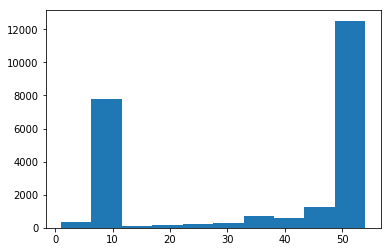

In [13]:
counter = Counter(train.srch_id)
counter.most_common()[:-10-1:-1]
plt.hist(list(counter.values()))

# Model Selection and Process the Data: Latent Factor Model

### Feature engineering

In [14]:
def create_imputation_map(df):
    na_columns = ['prop_price_with_discount_usd', 'prop_review_count', 
              'prop_review_score', 'srch_adults_cnt', 'srch_children_cnt']
    impute_dict = {}
    
    for column in na_columns:
        column_mean = np.nanmean(df[column], axis=0)
        impute_dict[column] = column_mean

    return impute_dict

In [15]:
def preprocessing(df, impute_dict):
    # remove columns that do not have enough datapoints or do not provide useful info
    new_df = df.drop(['srch_visitor_wr_member', 
                 'srch_visitor_loc_region',
                 'srch_posa_continent',
                 'srch_currency',
                 'srch_mobile_app',
                 'prop_imp_drr'], axis=1)
    
    # create a column of month for a particular search
    new_df['srch_local_month'] = pd.to_datetime(new_df['srch_local_date']).dt.month
    new_df['srch_checkin_month'] = pd.to_datetime(new_df['srch_ci']).dt.month
    new_df['srch_checkin_day'] = pd.to_datetime(new_df['srch_ci']).dt.day
    
    # impute columns with missing values     
    new_df.fillna(value = impute_dict, inplace=True)
    
    return new_df

In [16]:
impute_dict = create_imputation_map(train)
train_processed = preprocessing(train, impute_dict)
test_processed = preprocessing(test, impute_dict)

In [17]:
# train-val split, randomly select 10% of the user for validation
def split_train_val(df):
    user_list = df.srch_visitor_id.unique()
    m = len(user_list)
    new_user_list = deepcopy(user_list)
    random.shuffle(new_user_list)
    
    val_users_id = new_user_list[: int(0.1*m)]
    
    train_df = df[~df.srch_visitor_id.isin(val_users_id)]
    val_df = df[df.srch_visitor_id.isin(val_users_id)]
    
    return train_df, val_df

In [18]:
final_train, final_val = split_train_val(train_processed)

In [19]:
# Save processed dataframe 
train_processed_path = os.path.join(OUTPUT_PATH, "train_splited.pickle")
val_processed_path = os.path.join(OUTPUT_PATH, "val_splited.pickle")
#test_processed_path = os.path.join(OUTPUT_PATH, "test_processed.pickle")

with open(train_processed_path, 'wb') as trainOutput:
    pickle.dump(final_train, trainOutput)

with open(val_processed_path, 'wb') as valOutput:
    pickle.dump(final_val, valOutput)

In [19]:
print(final_train.srch_visitor_id.nunique())

20791


### Create user-item matrix

In [20]:
# Create a list of properties present in the train and test set
all_properties = list(set(train.prop_key.unique()).union(set(test.prop_key.unique())))

In [21]:
# Create user-property booking matrix
def create_user_property_matrix(df, properties_set):
    properties = np.sort(properties_set)
    users = np.sort(df.srch_visitor_id.unique())

    # map unique properties and users to index values
    properties_with_index = pd.DataFrame({'index_p':range(0,len(properties)), 'properties':properties})
    users_with_index = pd.DataFrame({'index_u':range(0,len(users)), 'users':users})

    # join dataframe with property and user index
    df_add_properties_index = df.join(properties_with_index.set_index('properties'), on='prop_key')
    df_add_users_properties_index = df_add_properties_index.join(users_with_index.set_index('users'), on='srch_visitor_id')
    
    # get the number of bookings per property-user pair
    num_bookings_df = df_add_users_properties_index.groupby(['index_p', 'index_u'])['prop_booking_bool'].sum().reset_index(name='num_booking')
    num_bookings_nonzero_df = num_bookings_df[num_bookings_df.num_booking != 0]
    
    booking_matrix = np.zeros((len(users), len(properties)))
    
    property_index = np.array(num_bookings_nonzero_df.index_p)
    user_index = np.array(num_bookings_nonzero_df.index_u)
    num_bookings = np.array(num_bookings_nonzero_df.num_booking)
    booking_matrix[user_index, property_index] = num_bookings
    
    return properties_with_index, users_with_index, booking_matrix

In [24]:
properties_idx_mapping, users_idx_mapping, user_property_booking_matrix = create_user_property_matrix(final_train, all_properties)

In [25]:
# Save index mapping and user_item_matrix 
properties_idx_mapping_path = os.path.join('output', 'train_splitted_properties_idx_mapping.pickle')
users_idx_mapping_path = os.path.join('output', 'orig_train_splitted_users_idx_mapping.pickle')
user_property_booking_matrix_path = os.path.join('output', 'train_splitted_user_property_matrix.pickle')

with open(properties_idx_mapping_path, 'wb') as output_prop:
    pickle.dump(properties_idx_mapping, output_prop)

with open(users_idx_mapping_path, 'wb') as output_user:
    pickle.dump(users_idx_mapping, output_user)
    
with open(user_property_booking_matrix_path, 'wb') as output_matrix:
    pickle.dump(user_property_booking_matrix, output_matrix)

### Define user and property parameters

In [31]:
# Create user features df
user_parameters = ['srch_visitor_visit_nbr',
                   'srch_dest_longitude',
                   'srch_dest_latitude',
                   'srch_checkin_month',
                   'srch_checkin_day',
                   'srch_ci_day', 
                   'srch_los', 
                   'srch_bw',
                   'srch_adults_cnt', 
                   'srch_children_cnt', 
                   'srch_rm_cnt', 
                   'srch_mobile_bool',
                   'srch_local_month'
                   ]

### Implicit feedback recommendation using logistic latent Factor model 

In [32]:
class LogisticMF():

    def __init__(self, counts, num_factors, iterations, reg_param=0.6, gamma=1.0):
        self.counts = counts
        self.num_users = counts.shape[0]
        self.num_items = counts.shape[1]
        self.num_factors = num_factors
        self.iterations = iterations
        self.reg_param = reg_param
        self.gamma = gamma

    def train_model(self):

        self.ones = np.ones((self.num_users, self.num_items))
        self.user_vectors = np.random.normal(size=(self.num_users, self.num_factors))
        self.item_vectors = np.random.normal(size=(self.num_items, self.num_factors))
        self.user_biases = np.random.normal(size=(self.num_users, 1))
        self.item_biases = np.random.normal(size=(self.num_items, 1))

        user_vec_deriv_sum = np.zeros((self.num_users, self.num_factors))
        item_vec_deriv_sum = np.zeros((self.num_items, self.num_factors))
        user_bias_deriv_sum = np.zeros((self.num_users, 1))
        item_bias_deriv_sum = np.zeros((self.num_items, 1))
        
        for i in range(self.iterations):
            t0 = time.time()
            # Fix items and solve for users
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            user_vec_deriv, user_bias_deriv = self.deriv(True)
            user_vec_deriv_sum += np.square(user_vec_deriv)
            user_bias_deriv_sum += np.square(user_bias_deriv)
            vec_step_size = self.gamma / np.sqrt(user_vec_deriv_sum)
            bias_step_size = self.gamma / np.sqrt(user_bias_deriv_sum)
            self.user_vectors += vec_step_size * user_vec_deriv
            self.user_biases += bias_step_size * user_bias_deriv

            # Fix users and solve for items
            # take step towards gradient of deriv of log likelihood
            # we take a step in positive direction because we are maximizing LL
            item_vec_deriv, item_bias_deriv = self.deriv(False)
            item_vec_deriv_sum += np.square(item_vec_deriv)
            item_bias_deriv_sum += np.square(item_bias_deriv)
            vec_step_size = self.gamma / np.sqrt(item_vec_deriv_sum)
            bias_step_size = self.gamma / np.sqrt(item_bias_deriv_sum)
            self.item_vectors += vec_step_size * item_vec_deriv
            self.item_biases += bias_step_size * item_bias_deriv
            t1 = time.time()

            print('iteration %i finished in %f seconds' % (i + 1, t1 - t0))

    def deriv(self, user):
        if user:
            vec_deriv = np.dot(self.counts, self.item_vectors)
            bias_deriv = np.expand_dims(np.sum(self.counts, axis=1), 1)

        else:
            vec_deriv = np.dot(self.counts.T, self.user_vectors)
            bias_deriv = np.expand_dims(np.sum(self.counts, axis=0), 1)
            
        A = np.dot(self.user_vectors, self.item_vectors.T)
        A += self.user_biases
        A += self.item_biases.T
        A = np.exp(A)
        A /= (A + self.ones)
        A = (self.counts + self.ones) * A

        if user:
            vec_deriv -= np.dot(A, self.item_vectors)
            bias_deriv -= np.expand_dims(np.sum(A, axis=1), 1)
            # L2 regularization
            vec_deriv -= self.reg_param * self.user_vectors
        else:
            vec_deriv -= np.dot(A.T, self.user_vectors)
            bias_deriv -= np.expand_dims(np.sum(A, axis=0), 1)
            # L2 regularization
            vec_deriv -= self.reg_param * self.item_vectors
            
        return (vec_deriv, bias_deriv)

    
    def log_likelihood(self):
        loglik = 0
        A = np.dot(self.user_vectors, self.item_vectors.T)
        A += self.user_biases
        A += self.item_biases.T
        B = A * self.counts
        loglik += np.sum(B)

        A = np.exp(A)
        A += self.ones

        A = np.log(A)
        A = (self.counts + self.ones) * A
        loglik -= np.sum(A)

        # L2 regularization
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.user_vectors))
        loglik -= 0.5 * self.reg_param * np.sum(np.square(self.item_vectors))
        return loglik

    
    def print_vectors(self):
        user_vecs_file = open('logmf-user-vecs-%i' % self.num_factors, 'w')
        for i in range(self.num_users):
            vec = ' '.join(map(str, self.user_vectors[i]))
            line = '%i\t%s\n' % (i, vec)
            user_vecs_file.write(line)
        user_vecs_file.close()
        item_vecs_file = open('logmf-item-vecs-%i' % self.num_factors, 'w')
        for i in range(self.num_items):
            vec = ' '.join(map(str, self.item_vectors[i]))
            line = '%i\t%s\n' % (i, vec)
            item_vecs_file.write(line)
        item_vecs_file.close()

### Initialize the model, train the model, and get user and item latent vectors 

In [33]:
def train_model(num_latent_factors, iterations, model_number, u_p_matrix):
    
    logistic_latent_factor_model = LogisticMF(u_p_matrix, num_latent_factors, iterations)
    
    logistic_latent_factor_model.train_model()
    
    user_vector_matrix = logistic_latent_factor_model.user_vectors
    item_vector_matrix = logistic_latent_factor_model.item_vectors
    
    # save results
    u_vector_file_name = os.path.join(OUTPUT_PATH, "train_splitted_" + str(model_number) + "_user_vector_matrix.pickle")
    i_vector_file_name = os.path.join(OUTPUT_PATH, "train_splitted_" + str(model_number) + "_item_vector_matrix.pickle")

    with open(u_vector_file_name, 'wb') as userMatrix:
        pickle.dump(user_vector_matrix, userMatrix)

    with open(i_vector_file_name, 'wb') as itemMatrix:
        pickle.dump(item_vector_matrix, itemMatrix)
        
    return user_vector_matrix, item_vector_matrix

#### Latent factor model 1: 100 latent factors, 60 iterations

In [33]:
# train the model
user_vector_matrix, item_vector_matrix = train_model(100, 60, 1)

iteration 1 finished in 9.000347 seconds
iteration 2 finished in 8.343534 seconds
iteration 3 finished in 8.295838 seconds
iteration 4 finished in 8.486530 seconds
iteration 5 finished in 8.576141 seconds
iteration 6 finished in 8.449510 seconds
iteration 7 finished in 8.515248 seconds
iteration 8 finished in 8.170882 seconds
iteration 9 finished in 8.341069 seconds
iteration 10 finished in 8.367486 seconds
iteration 11 finished in 8.672386 seconds
iteration 12 finished in 8.268026 seconds
iteration 13 finished in 8.781662 seconds
iteration 14 finished in 8.632397 seconds
iteration 15 finished in 8.706172 seconds
iteration 16 finished in 8.294159 seconds
iteration 17 finished in 8.653640 seconds
iteration 18 finished in 8.588908 seconds
iteration 19 finished in 8.654991 seconds
iteration 20 finished in 8.915171 seconds
iteration 21 finished in 8.830005 seconds
iteration 22 finished in 8.807927 seconds
iteration 23 finished in 8.661125 seconds
iteration 24 finished in 8.525918 seconds
i

## Model Prediction

In [42]:
# return top k similar visitors (most similar search queries) and their similarity score
# distance metric: cosine distance
def find_similar_user_index(target_row, train_df_unique_srchId, k_users):
    
    visitor_id_list = train_df_unique_srchId.srch_visitor_id
    train_df_user_parameters = np.array(train_df_unique_srchId[user_parameters])
    
    cosine_distance = cosine_similarity(target_row, train_df_user_parameters).reshape(train_df_user_parameters.shape[0],)
    
    srch_similarity_df = pd.DataFrame({'srch_visitor_id': visitor_id_list,
                                       'similarity': cosine_distance})
    
    top_k_similarity = srch_similarity_df.sort_values(by=['similarity'], ascending=False).head(k_users)
    
    return top_k_similarity

In [43]:
# find corresponding rows for k similar visitors in the user vector matrix
def find_rows_in_user_vector(top_k_df, user_vector_matrix):

    top_k_similar_users_df = top_k_df.join(users_idx_mapping.set_index('users'), on='srch_visitor_id')
    top_k_user_vectors_rows = user_vector_matrix[top_k_similar_users_df.index_u]
    
    return top_k_user_vectors_rows

In [44]:
# find corresponding row for the property in the item vector matrix
def find_target_property_in_item_vectors(prop_id, item_vector_matrix):
    prop_index = properties_idx_mapping[properties_idx_mapping['properties'] == prop_id].index_p.item()
    
    return item_vector_matrix[prop_index,:].reshape(item_vector_matrix.shape[1], 1)

In [45]:
# compute preference of k visitors
def compute_preference_k_users(user_vector_rows, item_vector_column):
    return np.dot(user_vector_rows, item_vector_column)

In [46]:
# compute the overall preference weighted by similarity
def compute_score(preference, similarity):
    return np.sum(np.multiply(preference, similarity))

In [48]:
results_path = os.path.join(OUTPUT_PATH, "test_pred_unordered_latent_factor_" + "1" + ".pickle")

In [52]:
def compute_scores_for_df(train_df, test_df, user_parameters, user_vector_matrix, 
                          item_vector_matrix, save_path, k_users):
    train_df_unique_srch_id = train_df.drop_duplicates(subset=['srch_id'])
    #train_user_parameters_array = np.array(train_df[user_parameters])
    result_df = pd.DataFrame({'srch_id':test_df.srch_id, 
                              'prop_key':test_df.prop_key, 
                              'score':np.zeros(test_df.shape[0])})
    
    def compute_score_update_row(target_row, row_index):
        target_srch_row = pd.DataFrame(target_row).transpose()
        target_srch_query = target_srch_row[user_parameters]
        
        top_k_similar_users_idx = find_similar_user_index(np.array(target_srch_query), \
                                                          train_df_unique_srch_id, k_users)
        user_vector_rows = find_rows_in_user_vector(top_k_similar_users_idx, user_vector_matrix)
        item_vector_row = find_target_property_in_item_vectors(target_srch_row.prop_key.item(), item_vector_matrix)
        
        preference_for_each_k_user = compute_preference_k_users(user_vector_rows, item_vector_row)
        result = compute_score(preference_for_each_k_user, np.array(top_k_similar_users_idx.similarity).reshape(k_users,1))
        result_df.loc[row_index, 'score'] = result

    for idx, row in notebook.tqdm(test_df.iterrows()):
        compute_score_update_row(row, idx)
        
    with open(save_path, 'wb') as output_result:
        pickle.dump(result_df, output_result)
    
    return result_df

#### Prediction for the validation set: weighted preference from 5 most similar users

In [50]:
results = compute_scores_for_df(final_train, final_val, user_parameters, user_vector_matrix, item_vector_matrix, k_users=5)

A Jupyter Widget

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [54]:
results_ordered = results.sort_values(by=['srch_id', 'score'], ascending = [True, False])
results_ordered_drop_score = results_ordered.drop(['score'], axis=1)

In [244]:
results_ordered_drop_score.to_csv('output/logit_latent_factor_results.csv', index=False)

## Model Evaluation

#### Metric: Percentage of users that booked the property in the top 5 list recommended in the latent factor model
#### DCG for each user @ 10

In [192]:
def calculate_DCG_at_top_k(booked_prop, recom_prop, rank_k):
    booked_set = set(booked_prop)
    recom_prop_top_k = recom_prop[:min(rank_k, len(recom_prop))]
    index_position = [i for i, e in enumerate(recom_prop_top_k) if e in booked_set]
    dcg = 0
    for index in index_position:
        dcg += 1/math.log(index+2, 2)     
    return dcg

def calc_dcg(res, val_info, rank_k):
    top_k_recommendation = res.groupby('srch_visitor_id')['prop_key'].apply(list).reset_index(name='recom_prop')
    top_k_recommendation_with_booked_prop = top_k_recommendation\
                                            .join(val_info.set_index('srch_visitor_id'), 
                                                  on ='srch_visitor_id',
                                                  how = 'inner')
        
    top_k_recommendation_with_booked_prop['index'] = top_k_recommendation_with_booked_prop\
                                                    .apply(lambda row : calculate_DCG_at_top_k(row['booked_prop'], 
                                                                                               row['recom_prop'],
                                                                                               rank_k), 
                                                           axis = 1)   
        
    return top_k_recommendation_with_booked_prop     

In [105]:
# join result with their user_id
res_with_visitor_id = results_ordered_drop_score.join(final_val[['srch_id', 'srch_visitor_id']]\
                                                      .set_index('srch_id'), on = 'srch_id')

# get booking records for visitors in the validation set
user_with_booked_prop = final_val[final_val.prop_booking_bool == 1][['srch_id', 'srch_visitor_id', 'prop_key']]
booked_prop_groupby_user = user_with_booked_prop.groupby('srch_visitor_id')['prop_key'].apply(list).reset_index(name='booked_prop')  

In [183]:
dcg_for_each_user = calc_dcg(res_with_visitor_id, booked_prop_groupby_user, 10)

In [184]:
dcg_all_users = np.mean(dcg_for_each_user[['index']])
print("dcg@10: " + str(dcg_all_users.item()))

dcg@10: 0.4318624145110424


## Put model training and evaluation functions together 

In [337]:
def latent_factor_model_training(num_latent_factors, iterations, model_number, user_property_matrix):
    user_vector_matrix, item_vector_matrix = train_model(num_latent_factors, iterations, model_number, user_property_matrix)
    
    results_path = os.path.join(OUTPUT_PATH, "final_tuned_pred_unordered_latent_factor_" + str(model_number) + ".pickle")
    
    #results = compute_scores_for_df(final_train, final_val, user_parameters, user_vector_matrix, item_vector_matrix, results_path, k_users=5)
    results = compute_scores_for_df(train_processed, test_processed, user_parameters, user_vector_matrix, item_vector_matrix, results_path, k_users=5)
    
    results_ordered = results.sort_values(by=['srch_id', 'score'], ascending = [True, False])
    #results_ordered_drop_score = results_ordered.drop(['score'], axis=1)
    
    return results_ordered


def latent_factor_model_evaluation(ordered_results, val_set, val_booking_info):
    
    res_with_visitor_id = ordered_results.join(val_set[['srch_id', 'srch_visitor_id']]\
                                                      .set_index('srch_id'), on = 'srch_id')

    dcg_for_each_user = calc_dcg(res_with_visitor_id, val_booking_info, rank_k=10)
    
    dcg_all_users = np.mean(dcg_for_each_user[['index']])
    #print("dcg@10: " + str(dcg_all_users.item()))
    
    return dcg_all_users.item()  

#### Latent factor model 2: 20 latent factors, 100 iterations

In [313]:
# get booking records for visitors in the validation set
#user_with_booked_prop = final_val[final_val.prop_booking_bool == 1][['srch_id', 'srch_visitor_id', 'prop_key']]
#booked_prop_groupby_user = user_with_booked_prop.groupby('srch_visitor_id')['prop_key'].apply(list).reset_index(name='booked_prop')

result_ordered_2 = latent_factor_model_training(20, 100, 2)
dcg_for_all_users_2 = latent_factor_model_evaluation(result_ordered_2, final_val, booked_prop_groupby_user)
print(dcg_for_all_users_2)

iteration 1 finished in 8.308824 seconds
iteration 2 finished in 8.098759 seconds
iteration 3 finished in 8.051920 seconds
iteration 4 finished in 8.225375 seconds
iteration 5 finished in 7.821528 seconds
iteration 6 finished in 7.719490 seconds
iteration 7 finished in 7.799818 seconds
iteration 8 finished in 7.829719 seconds
iteration 9 finished in 7.905992 seconds
iteration 10 finished in 7.978943 seconds
iteration 11 finished in 8.086609 seconds
iteration 12 finished in 8.233547 seconds
iteration 13 finished in 8.116977 seconds
iteration 14 finished in 8.055948 seconds
iteration 15 finished in 7.990087 seconds
iteration 16 finished in 8.081241 seconds
iteration 17 finished in 8.027063 seconds
iteration 18 finished in 8.005428 seconds
iteration 19 finished in 7.847799 seconds
iteration 20 finished in 8.382077 seconds
iteration 21 finished in 8.005615 seconds
iteration 22 finished in 7.711496 seconds
iteration 23 finished in 7.651276 seconds
iteration 24 finished in 8.851140 seconds
i

A Jupyter Widget

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



0.3749542317770752


#### Latent factor model 3: 60 latent facotrs, 150 iterations

In [314]:
result_ordered_3 = latent_factor_model_training(60, 150, 3)
dcg_for_all_users_3 = latent_factor_model_evaluation(result_ordered_3, final_val, booked_prop_groupby_user)
print(dcg_for_all_users_3)

iteration 1 finished in 8.547319 seconds
iteration 2 finished in 8.036836 seconds
iteration 3 finished in 8.074390 seconds
iteration 4 finished in 8.061693 seconds
iteration 5 finished in 8.017559 seconds
iteration 6 finished in 8.080949 seconds
iteration 7 finished in 8.053395 seconds
iteration 8 finished in 7.966269 seconds
iteration 9 finished in 8.040052 seconds
iteration 10 finished in 8.048553 seconds
iteration 11 finished in 8.385144 seconds
iteration 12 finished in 8.039587 seconds
iteration 13 finished in 7.982268 seconds
iteration 14 finished in 7.983535 seconds
iteration 15 finished in 8.242350 seconds
iteration 16 finished in 8.086089 seconds
iteration 17 finished in 8.008594 seconds
iteration 18 finished in 7.997565 seconds
iteration 19 finished in 8.055492 seconds
iteration 20 finished in 8.029889 seconds
iteration 21 finished in 8.008946 seconds
iteration 22 finished in 8.180729 seconds
iteration 23 finished in 8.071341 seconds
iteration 24 finished in 7.989797 seconds
i

A Jupyter Widget

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



0.45782058604718023


#### Latent factor model 4: 125 latent factors, 100 iterations

In [315]:
result_ordered_4 = latent_factor_model_training(125, 100, 4)
dcg_for_all_users_4 = latent_factor_model_evaluation(result_ordered_4, final_val, booked_prop_groupby_user)
print(dcg_for_all_users_4)

iteration 1 finished in 9.138504 seconds
iteration 2 finished in 8.635266 seconds
iteration 3 finished in 8.563531 seconds
iteration 4 finished in 9.103434 seconds
iteration 5 finished in 8.643828 seconds
iteration 6 finished in 8.512614 seconds
iteration 7 finished in 8.527029 seconds
iteration 8 finished in 8.574532 seconds
iteration 9 finished in 8.506694 seconds
iteration 10 finished in 8.555544 seconds
iteration 11 finished in 8.570706 seconds
iteration 12 finished in 8.843381 seconds
iteration 13 finished in 8.510568 seconds
iteration 14 finished in 8.527646 seconds
iteration 15 finished in 8.551603 seconds
iteration 16 finished in 8.551183 seconds
iteration 17 finished in 9.299714 seconds
iteration 18 finished in 8.926976 seconds
iteration 19 finished in 8.558219 seconds
iteration 20 finished in 8.401079 seconds
iteration 21 finished in 9.238536 seconds
iteration 22 finished in 9.055114 seconds
iteration 23 finished in 8.576230 seconds
iteration 24 finished in 8.589538 seconds
i

A Jupyter Widget

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



0.4611140349019519


### Observations
The latent factor model with 125 latent factors and 100 iterations have the highest DCG@10. 

## Ensemble Model
### Incorporating popularity, price, and average ratings

In [57]:
def ensemble_model(train_set, latent_factor_res, latent_weight, popu_weight, price_weight, review_weight):
    
    def create_popu_price_review_df(train_set):
        # get the number of bookings, average price, and average ratings for properties in the train set        
        train_groupby_columns = train_set.groupby("prop_key").agg(
                {'prop_booking_bool': np.sum, 
                 'prop_price_with_discount_usd' : lambda x : np.mean(x),
                 'prop_review_score': lambda x :  np.mean(x)})
    
        return train_groupby_columns
    
    def scale_to_zero_one_range(grouped_df):
        # normalize the data to 0 to 1
        scaler = MinMaxScaler()
        grouped_df_scaled = scaler.fit_transform(grouped_df)
        scaled_df = pd.DataFrame(grouped_df_scaled, 
                                 columns = grouped_df.columns,
                                index = grouped_df.index)
        scaled_df.reset_index(inplace=True)
        
        return scaled_df
    
    def scale_latent_score(latent_factor_res):
        scaler = MinMaxScaler()
        latent_factor_res['scaled_latent_factor_score'] = scaler.fit_transform(latent_factor_res[['score']])
        latent_factor_remove_orig_score = latent_factor_res.drop(['score'], axis=1)
        
        return latent_factor_remove_orig_score    
    
    def combine_score(latent_factor_result, popu_price_review_result):
        combined_df = latent_factor_result.join(popu_price_review_result.set_index('prop_key'), on = 'prop_key', how = 'inner')
        
        return combined_df
    
    def linear_combine_score(latent_weight, popu_weight, price_weight, review_weight, df):
        df['score'] = latent_weight * df['scaled_latent_factor_score'] + \
                                 popu_weight * df['prop_booking_bool'] + \
                                 price_weight * df['prop_price_with_discount_usd'] + \
                                 review_weight * df['prop_review_score']
                    
        return df
    
    def reorder_and_remove_other_columns(df):
        results_ordered = df.sort_values(by=['srch_id', 'score'], ascending = [True, False])
        final_result = results_ordered[['srch_id', 'prop_key']]
        
        return final_result
        
    popu_price_review_df = create_popu_price_review_df(train_set)
    popu_price_review_df_scaled = scale_to_zero_one_range(popu_price_review_df)
    latent_score_scaled = scale_latent_score(latent_factor_res)
    
    combined_df = combine_score(latent_score_scaled, popu_price_review_df_scaled)
    df_final_score = linear_combine_score(latent_weight, popu_weight, price_weight, review_weight, combined_df)
    result_final_combined_score = reorder_and_remove_other_columns(df_final_score)

    return result_final_combined_score

In [330]:
ensemble_sample_res = ensemble_model(final_train, result_ordered_4, 1, 5, -1, 1)

In [318]:
dcg_for_all_users = latent_factor_model_evaluation(ensemble_sample_res, final_val, booked_prop_groupby_user)
print(dcg_for_all_users)

0.43863247870470323


### Weights tuning based on grid search

In [319]:
latent_weight_grid = [0.03, 0.3, 3, 30]
popu_weight_grid = [0.03, 0.3, 3, 30]
price_weight_grid = [-0.03, -0.3, -3, -30]
review_weight_grid = [0.03, 0.3, 3, 30]
grid_search_columns = ["latent_weight", "popu_weight", "price_weight", "review_weight", "dcg_score"]
data = []

for la in latent_weight_grid:
    for po in popu_weight_grid:
        for pr in price_weight_grid:
            for re in review_weight_grid:
                params_value = {"train_set": final_train,
                                "latent_factor_res": result_ordered_4,
                                "latent_weight": la, 
                                "popu_weight": po, 
                                "price_weight": pr, 
                                "review_weight": re}
                
                ensemble_res = ensemble_model(**params_value)
                dcg_for_all_users = latent_factor_model_evaluation(ensemble_res, final_val, booked_prop_groupby_user)
                data.append([la, po, pr, re, dcg_for_all_users])
                
grid_search_result = pd.DataFrame(data, columns=grid_search_columns)

In [320]:
grid_search_result.sort_values(['dcg_score'], ascending=False)

,latent_weight,popu_weight,price_weight,review_weight,dcg_score
72,0.30,0.03,-3.00,0.03,0.487499
157,3.00,0.30,-30.00,0.30,0.487499
140,3.00,0.03,-30.00,0.03,0.485009
141,3.00,0.03,-30.00,0.30,0.481040
68,0.30,0.03,-0.30,0.03,0.476011
238,30.00,3.00,-30.00,3.00,0.476011
153,3.00,0.30,-3.00,0.30,0.476011
232,30.00,3.00,-3.00,0.03,0.475627
224,30.00,3.00,-0.03,0.03,0.475627
228,30.00,3.00,-0.30,0.03,0.475627


In [321]:
latent_weight_grid = [0.5, 1, 1.5]
popu_weight_grid = [0.05, 0.1, 0.2]
price_weight_grid = [-10, -15, -25]
review_weight_grid = [0.05, 0.1, 0.2]
grid_search_columns = ["latent_weight", "popu_weight", "price_weight", "review_weight", "dcg_score"]
data_2 = []

for la in latent_weight_grid:
    for po in popu_weight_grid:
        for pr in price_weight_grid:
            for re in review_weight_grid:
                params_value = {"train_set": final_train,
                                "latent_factor_res": result_ordered_4,
                                "latent_weight": la, 
                                "popu_weight": po, 
                                "price_weight": pr, 
                                "review_weight": re}
                
                ensemble_res = ensemble_model(**params_value)
                dcg_for_all_users = latent_factor_model_evaluation(ensemble_res, final_val, booked_prop_groupby_user)
                data_2.append([la, po, pr, re, dcg_for_all_users])
                
grid_search_result_2 = pd.DataFrame(data_2, columns=grid_search_columns)

In [322]:
grid_search_result_2.sort_values(['dcg_score'], ascending=False)

,latent_weight,popu_weight,price_weight,review_weight,dcg_score
65,1.5,0.10,-10,0.20,0.495463
55,1.5,0.05,-10,0.10,0.490734
64,1.5,0.10,-10,0.10,0.487566
37,1.0,0.10,-10,0.10,0.487499
73,1.5,0.20,-10,0.10,0.487224
63,1.5,0.10,-10,0.05,0.487065
72,1.5,0.20,-10,0.05,0.486973
75,1.5,0.20,-15,0.05,0.484445
36,1.0,0.10,-10,0.05,0.482357
67,1.5,0.10,-15,0.10,0.481937


In [323]:
latent_weight_grid = [1, 1.2, 1.4]
popu_weight_grid = [0.06, 0.75, 0.09]
price_weight_grid = [-10]
review_weight_grid = [0.12, 0.15, 0.18]
grid_search_columns = ["latent_weight", "popu_weight", "price_weight", "review_weight", "dcg_score"]
data_3 = []

for la in latent_weight_grid:
    for po in popu_weight_grid:
        for pr in price_weight_grid:
            for re in review_weight_grid:
                params_value = {"train_set": final_train,
                                "latent_factor_res": result_ordered_4,
                                "latent_weight": la, 
                                "popu_weight": po, 
                                "price_weight": pr, 
                                "review_weight": re}
                
                ensemble_res = ensemble_model(**params_value)
                dcg_for_all_users = latent_factor_model_evaluation(ensemble_res, final_val, booked_prop_groupby_user)
                data_3.append([la, po, pr, re, dcg_for_all_users])
                
grid_search_result_3 = pd.DataFrame(data_2, columns=grid_search_columns)

In [324]:
grid_search_result_3.sort_values(['dcg_score'], ascending=False)

,latent_weight,popu_weight,price_weight,review_weight,dcg_score
65,1.5,0.10,-10,0.20,0.495463
55,1.5,0.05,-10,0.10,0.490734
64,1.5,0.10,-10,0.10,0.487566
37,1.0,0.10,-10,0.10,0.487499
73,1.5,0.20,-10,0.10,0.487224
63,1.5,0.10,-10,0.05,0.487065
72,1.5,0.20,-10,0.05,0.486973
75,1.5,0.20,-15,0.05,0.484445
36,1.0,0.10,-10,0.05,0.482357
67,1.5,0.10,-15,0.10,0.481937


### Final parameters
- latent_weight = 1.5
- popularity_weight = 0.1
- price_weight = -10
- review_weight = 0.2
- number of latent factors: 125
- training iterations: 100


### Generate results for the entire training set based on selected parameters

In [22]:
properties_idx_mapping, users_idx_mapping, user_property_booking_matrix = create_user_property_matrix(train_processed, all_properties)

In [34]:
user_vector_matrix, item_vector_matrix = train_model(125, 100, 0, user_property_booking_matrix)

iteration 1 finished in 10.773543 seconds
iteration 2 finished in 9.647498 seconds
iteration 3 finished in 9.905503 seconds
iteration 4 finished in 9.319237 seconds
iteration 5 finished in 9.497583 seconds
iteration 6 finished in 9.272575 seconds
iteration 7 finished in 9.255271 seconds
iteration 8 finished in 9.326726 seconds
iteration 9 finished in 9.471587 seconds
iteration 10 finished in 9.443905 seconds
iteration 11 finished in 9.353863 seconds
iteration 12 finished in 9.578443 seconds
iteration 13 finished in 9.608833 seconds
iteration 14 finished in 9.384641 seconds
iteration 15 finished in 9.380008 seconds
iteration 16 finished in 9.834795 seconds
iteration 17 finished in 9.494722 seconds
iteration 18 finished in 9.509276 seconds
iteration 19 finished in 9.590548 seconds
iteration 20 finished in 9.522426 seconds
iteration 21 finished in 10.913183 seconds
iteration 22 finished in 10.766535 seconds
iteration 23 finished in 9.502840 seconds
iteration 24 finished in 9.558577 second

In [53]:
results_path = os.path.join(OUTPUT_PATH, "final_tuned_pred_unordered_latent_factor.pickle")
results_final_tuned = compute_scores_for_df(train_processed, test_processed, user_parameters, user_vector_matrix, item_vector_matrix, results_path, k_users=5)
    
results_final_tuned_ordered = results_final_tuned.sort_values(by=['srch_id', 'score'], ascending = [True, False])

A Jupyter Widget

In [59]:
ensemble_final_tuned = ensemble_model(train_processed, results_final_tuned_ordered, 1.5, 0.1, -10, 0.2)
ensemble_final_tuned

,srch_id,prop_key
259647,-2147403968,287623
259631,-2147403968,278277
259625,-2147403968,270584
259632,-2147403968,364047
259644,-2147403968,289794
...,...,...
129511,2146902698,3885482
129526,2146902698,256516
129519,2146902698,268299
129505,2146902698,292812


In [60]:
ensemble_final_tuned.to_csv('output/ensemble_model_final_tuned_results.csv', index=False)

# Challanges and Next Steps

### Challenges

- Most users have only one booking
- Test set is mostly unseen users
- Implicit feedback


### Next Steps

- Use locality-sensitive hashing to speed up the process of finding similar users
- Hypermeter tuning
- Try incorporating LambdaMART model
- Try incorporating user preference as features and use logistic and random forest model
